# Setup

In [1]:
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import fasttext.util
import numpy as np

import plotly.express as px
from sklearn.manifold import TSNE
import gensim

import nltk
import nltk.downloader

fasttext.util.download_model("pl", if_exists="ignore")

if not os.path.exists("nkjp+wiki-forms-all-100-cbow-hs.txt"):
    raise ValueError(
        "Download the model from http://dsmodels.nlp.ipipan.waw.pl/dsmodels/nkjp+wiki-forms-all-100-cbow-hs.txt.gz and extract it to the root of the project"
    )


if not nltk.downloader.Downloader().is_installed("punkt_tab"):
    nltk.download("punkt_tab")

/usr/lib/python3/dist-packages/paramiko/transport.py:237: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [31]:
model_fasttext = fasttext.load_model("cc.pl.300.bin")

In [38]:
model_word2vec = gensim.models.KeyedVectors.load_word2vec_format(
    "nkjp+wiki-forms-all-100-cbow-hs.txt"
)

In [2]:
import pandas as pd

excel_file = 'save_data/annotations_all_batches.xlsx'
data = pd.DataFrame()
for sheet in ["WORD - FIRST BATCH", "WORD - SECOND BATCH"]:
    df = pd.read_excel(excel_file, sheet_name=sheet, header=8, usecols='A:H')
    data = pd.concat([data, df])

data.rename(columns={"text": "sentence"}, inplace=True)
target_map = {
    0: "NEG",
    1: "NEU",
    2: "POS",
    3: "O",}

target_map_combine = {
    0: "NEG",
    1: "NEU/O",
    2: "POS",
    3: "NEU/O",}
data['target'] = data['Finalna anotacja'].map(target_map)
data['target_combine'] = data['Finalna anotacja'].map(target_map_combine)
data

,sentence_id,word_id,word,Olek,Kuba,Zgodne?,Stachu,Finalna anotacja,target,target_combine
0,1,1,Generalnie,0,1,N,0.0,0,NEG,NEG
1,1,2,nie,2,1,N,2.0,2,POS,POS
2,1,3,mam,2,1,N,2.0,2,POS,POS
3,1,4,żadnych,2,1,N,2.0,2,POS,POS
4,1,5,zastrzeżeń,2,1,N,2.0,2,POS,POS
...,...,...,...,...,...,...,...,...,...,...
262,5,48,vesaWygląda,1,1,T,NaN,1,NEU,NEU/O
263,5,49,też,3,3,T,NaN,3,O,NEU/O
264,5,50,super,2,2,T,NaN,2,POS,POS
265,5,51,Solidny,2,2,T,NaN,2,POS,POS


# 1. FastText embedding

In [33]:
# vectorize the words with FastText
vectors_fasttext = []
annotations_fasttext = (
    []
)  # annotations for words that have a vector in fasttext (some words may not have a vector)
words_used_fasttext = []  # words that have a vector in fasttext
annotations_fasttext_combine = (
    []
)

for idx, word in enumerate(data['word']):
    if word in model_fasttext.words:
        vectorized = model_fasttext.get_word_vector(word)
        vectors_fasttext.append(vectorized)
        annotations_fasttext.append(data['target'].iloc[idx])
        annotations_fasttext_combine.append(data['target_combine'].iloc[idx])
        words_used_fasttext.append(word)


vectors_fasttext = np.array(vectors_fasttext)
annotations_fasttext = np.array(annotations_fasttext)
np.save("save_data/word_vectors_fasttext.npy", vectors_fasttext)
np.save("save_data/word_annotations_fasttext.npy", annotations_fasttext)
np.save("save_data/annotations_fasttext_combine.npy", annotations_fasttext_combine)
np.save("save_data/words_used_fasttext.npy", words_used_fasttext)

In [3]:
vectors_fasttext = np.load("save_data/word_vectors_fasttext.npy")
annotations_fasttext = np.load("save_data/word_annotations_fasttext.npy")
words_used_fasttext = np.load("save_data/words_used_fasttext.npy")
annotations_fasttext_combine = np.load("save_data/annotations_fasttext_combine.npy")

In [4]:
# reduce dimensionality
tsne_fasttext = TSNE(n_components=2, random_state=42)
vectors_fasttext_embedded = tsne_fasttext.fit_transform(vectors_fasttext)

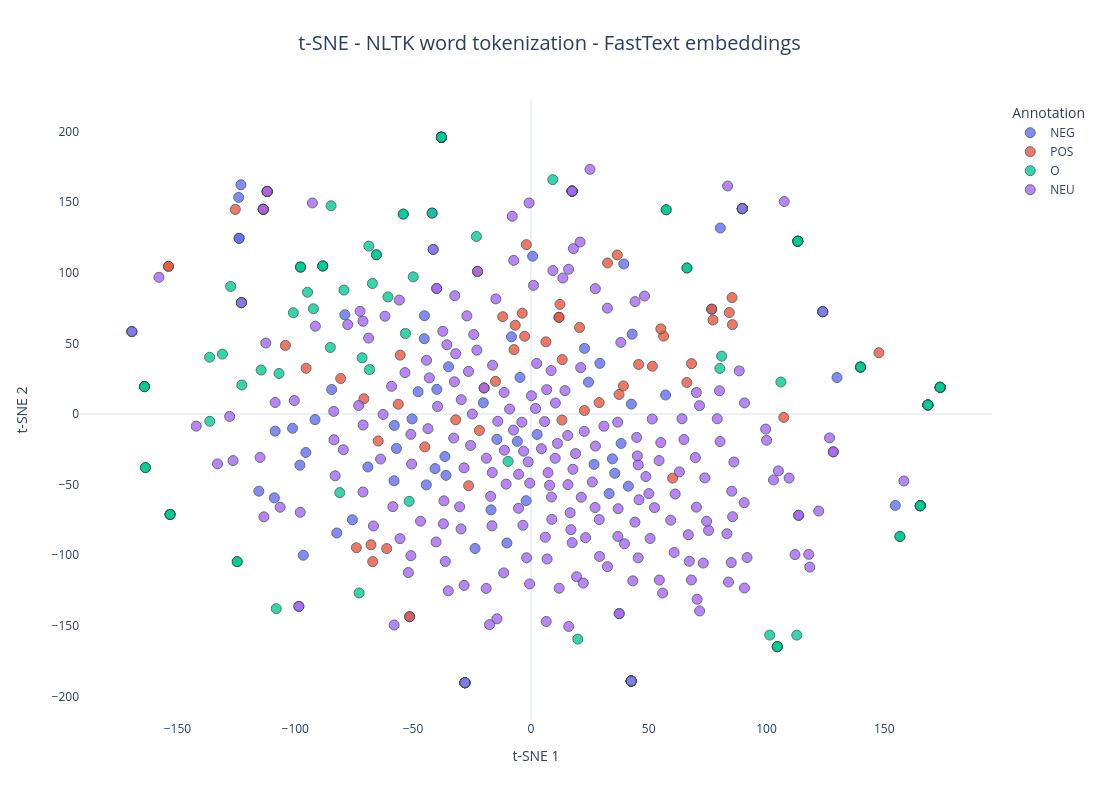

In [6]:
fig = px.scatter(
    x=vectors_fasttext_embedded[:, 0],
    y=vectors_fasttext_embedded[:, 1],
    color=annotations_fasttext,
    hover_data={"word": words_used_fasttext, "annotation": annotations_fasttext},
    title="t-SNE - NLTK word tokenization - FastText embeddings",
    labels={"color": "Annotation", "x": "t-SNE 1", "y": "t-SNE 2"},
    color_continuous_scale=px.colors.sequential.Viridis,
    template="plotly_white",
)

fig.update_traces(
    marker=dict(size=10, opacity=0.8, line=dict(width=1, color="DarkSlateGrey"))
)
fig.update_layout(
    title_font_size=20,
    title_x=0.5,
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
    coloraxis_colorbar=dict(title="Annotation"),
    legend_title_text="Annotation",
    width=1100,
    height=800,
)

fig.show()

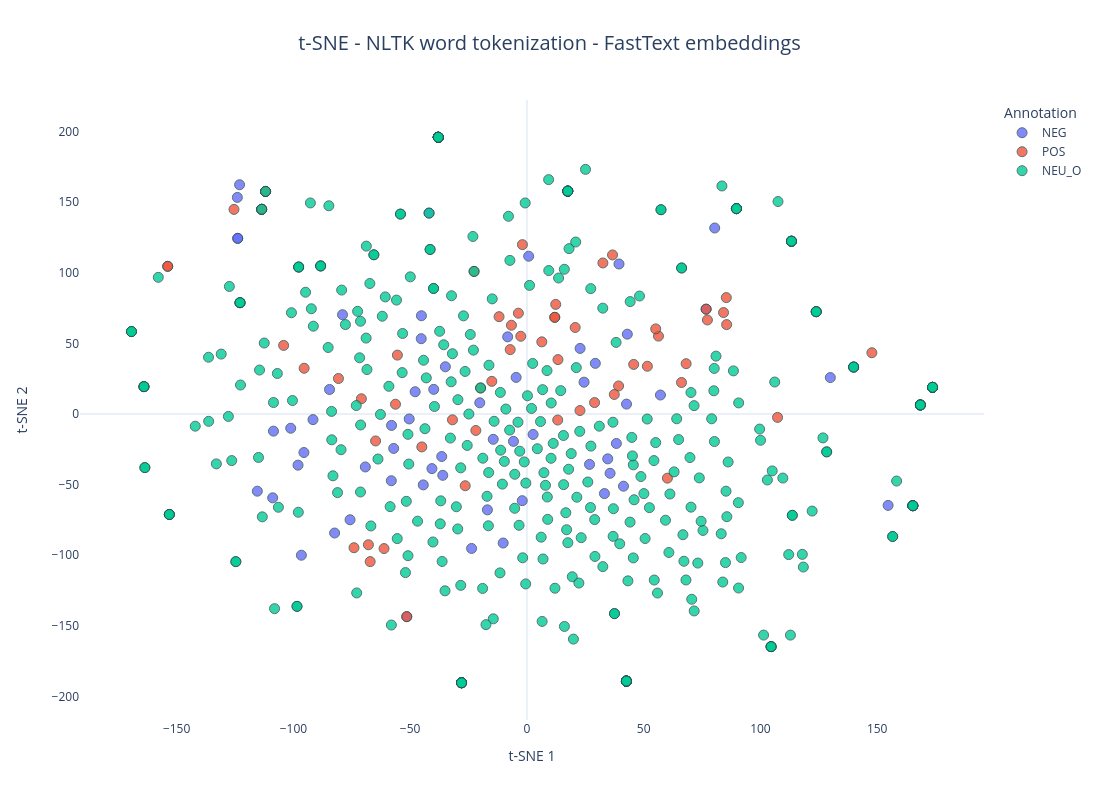

In [8]:
fig = px.scatter(
    x=vectors_fasttext_embedded[:, 0],
    y=vectors_fasttext_embedded[:, 1],
    color=annotations_fasttext_combine,
    hover_data={"word": words_used_fasttext, "annotation": annotations_fasttext},
    title="t-SNE - NLTK word tokenization - FastText embeddings",
    labels={"color": "Annotation", "x": "t-SNE 1", "y": "t-SNE 2"},
    color_continuous_scale=px.colors.sequential.Viridis,
    template="plotly_white",
)

fig.update_traces(
    marker=dict(size=10, opacity=0.8, line=dict(width=1, color="DarkSlateGrey"))
)
fig.update_layout(
    title_font_size=20,
    title_x=0.5,
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
    coloraxis_colorbar=dict(title="Annotation"),
    legend_title_text="Annotation",
    width=1100,
    height=800,
)

fig.show()

In [9]:
len(vectors_fasttext_embedded[:, 1])

518

# 2. Word2Vec embedding

In [39]:
# vectorize the words with Word2Vec
vectors_word2vec = []
annotations_word2vec = (
    []
)  # annotations for words that have a vector in word2vec (some words may not have a vector)
words_used_word2vec = []  # words that have a vector in word2vec

annotations_word2vec_combine = (
    []
)
for idx, word in enumerate(data['word']):
    if model_word2vec.has_index_for(word):
        vectorized = model_word2vec.get_vector(word)
        vectors_word2vec.append(vectorized)
        annotations_word2vec.append(data['target'].iloc[idx])
        annotations_word2vec_combine.append(data['target_combine'].iloc[idx])
        words_used_word2vec.append(word)

vectors_word2vec = np.array(vectors_word2vec)
annotations_word2vec = np.array(annotations_word2vec)

np.save("save_data/word_vectors_word2vec.npy", vectors_word2vec)
np.save("save_data/word_annotations_word2vec.npy", annotations_word2vec)
np.save("save_data/annotations_word2vec_combine.npy", annotations_word2vec_combine)
np.save("save_data/words_used_word2vec.npy", words_used_word2vec)

In [10]:
vectors_word2vec = np.load("save_data/word_vectors_word2vec.npy")
annotations_word2vec = np.load("save_data/word_annotations_word2vec.npy")
words_used_word2vec = np.load("save_data/words_used_word2vec.npy")
annotations_word2vec_combine = np.load("save_data/annotations_word2vec_combine.npy")

In [11]:
# reduce dimensionality
tsne_word2vec = TSNE(n_components=2, random_state=42)
vectors_word2vec_embedded = tsne_fasttext.fit_transform(vectors_word2vec)

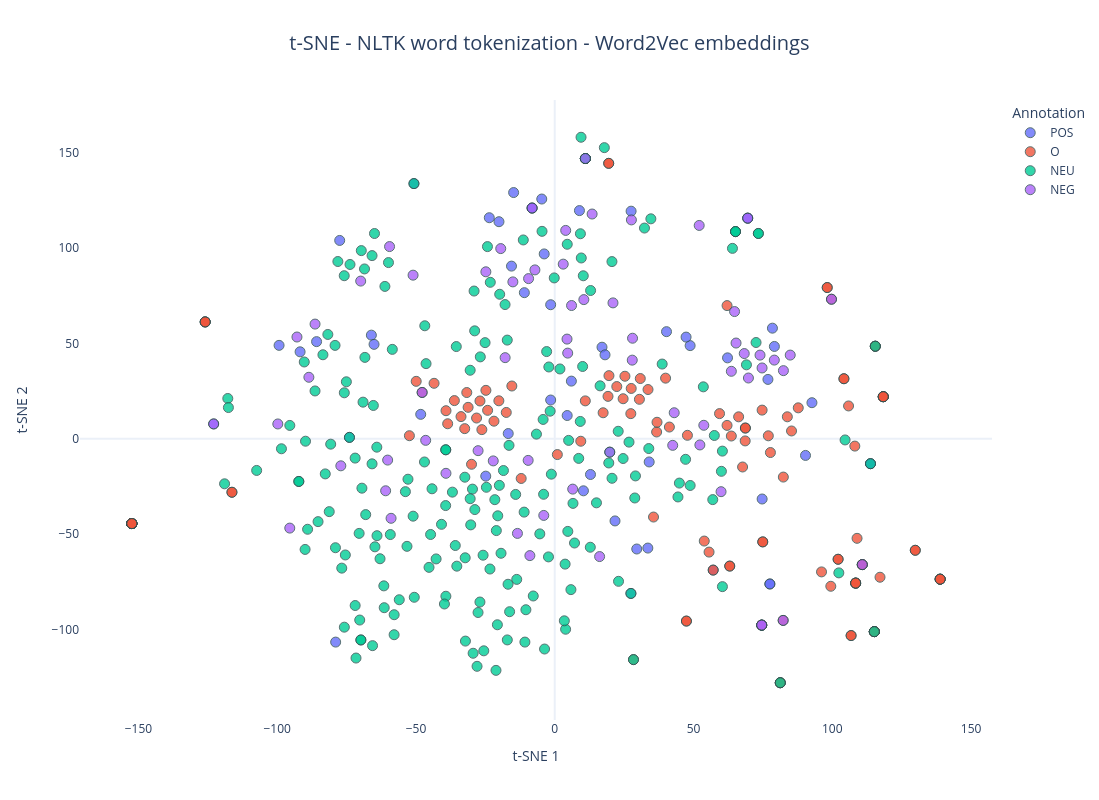

In [12]:
fig = px.scatter(
    x=vectors_word2vec_embedded[:, 0],
    y=vectors_word2vec_embedded[:, 1],
    color=annotations_word2vec,
    hover_data={"word": words_used_word2vec, "annotation": annotations_word2vec},
    title="t-SNE - NLTK word tokenization - Word2Vec embeddings",
    labels={"color": "Annotation", "x": "t-SNE 1", "y": "t-SNE 2"},
    color_continuous_scale=px.colors.sequential.Viridis,
    template="plotly_white",
)

fig.update_traces(
    marker=dict(size=10, opacity=0.8, line=dict(width=1, color="DarkSlateGrey"))
)
fig.update_layout(
    title_font_size=20,
    title_x=0.5,
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
    coloraxis_colorbar=dict(title="Annotation"),
    legend_title_text="Annotation",
    width=1100,
    height=800,
)

fig.show()

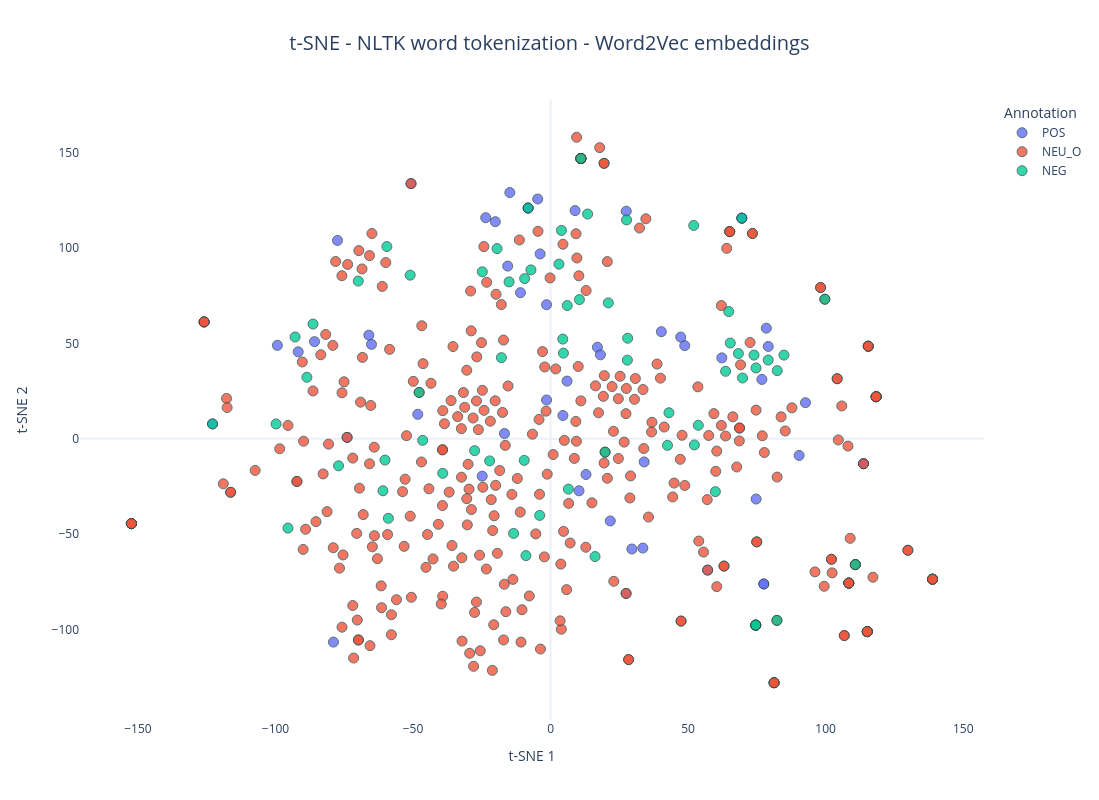

In [13]:
fig = px.scatter(
    x=vectors_word2vec_embedded[:, 0],
    y=vectors_word2vec_embedded[:, 1],
    color=annotations_word2vec_combine,
    hover_data={"word": words_used_word2vec, "annotation": annotations_word2vec},
    title="t-SNE - NLTK word tokenization - Word2Vec embeddings",
    labels={"color": "Annotation", "x": "t-SNE 1", "y": "t-SNE 2"},
    color_continuous_scale=px.colors.sequential.Viridis,
    template="plotly_white",
)

fig.update_traces(
    marker=dict(size=10, opacity=0.8, line=dict(width=1, color="DarkSlateGrey"))
)
fig.update_layout(
    title_font_size=20,
    title_x=0.5,
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
    coloraxis_colorbar=dict(title="Annotation"),
    legend_title_text="Annotation",
    width=1100,
    height=800,
)

fig.show()

# 3. Compare k-nearest words results

In [19]:
annotated_words = [
    "zły",
    "użyteczna",
    "okropnie",
    "znakomicie",
    "brzydki",
    "polecam",
    "zdecydowanie",
    "absolutnie",
]  # you may replace it with words annotated in the task

common_words = (
    set(words_used_fasttext)
    .intersection(set(words_used_word2vec))
    .intersection(set(annotated_words))
)

In [20]:
common_words

{'polecam'}

In [36]:
k = 5

for word in common_words:
    print(f"Word: {word}")
    print("FastText:")
    results = model_fasttext.get_nearest_neighbors(word, k=k)
    print([res for _, res in results])

Word: polecam
FastText:
['Polecam', 'polecam-', 'odradzam', '-polecam', 'polecamy']


In [ ]:
k = 5

for word in common_words:
    print(f"Word: {word}")
    print("FastText:")
    results = model_fasttext.get_nearest_neighbors(word, k=k)
    print([res for _, res in results])

Word: polecam
FastText:
['Polecam', 'polecam-', 'odradzam', '-polecam', 'polecamy']


In [40]:
for word in common_words:
    print("Word2Vec:")
    results = model_word2vec.most_similar(positive=word, topn=k)
    print([res for res, _ in results])
    print()

Word2Vec:
['zalecam', 'odradzam', 'podsyłam', 'polecem', 'podrzucam']

